# Time Series Analysis with Deep Learning 
Time series analysis is an approach to analyze time series data to extract meaningful characteristics of data and generate other useful insights applied in business situation. 
### Steps in the process
- Preprocessing
- Define neural network shape and Model Compilation
- Fit Model
- Evaluation
- Visualize prediction
### Models
- DNNs
- RNNs
- LSTM

In [1]:
# adding libraries
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))
import warnings
warnings.filterwarnings('ignore')
import logging
logging.basicConfig(level=os.environ.get("LOGLEVEL", "INFO"))

In [2]:
# Importing Pandas an Numpy Libraries to use on manipulating our Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.preprocessing import MinMaxScaler
# To evaluate end result we have
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import tensorflow_addons as tfa
import mlflow

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [3]:
import warnings
warnings.filterwarnings('ignore')
import dvc.api

### Custom library

In [6]:
from utility import ReadData
from  Preprocessing import dataPreprocess
# from logger import App_Logger
from data_info import DataInfo
import plotfunction
import util as u

INFO:root:data info: displying datatype


In [4]:
# this train data contains the merged data and versioned with DVC
def get_data(tag, 
            path='data/train.csv', 
            repo ='C:/Users/Ekubay/Documents/Rossmann_Pharmaceutical_sales_Prediction'
):
    rev = tag
    data_url = dvc.api.get_url(path=path, repo=repo, rev=rev)
    df = pd.read_csv(data_url)
    return df

In [5]:
df_train = get_data('ver_4')

In [25]:
df_test = pd.read_csv('../data/test.csv')

In [26]:
#df_tests = get_data('ver_5')

In [27]:
df_test.shape

(41088, 8)

In [7]:
df_train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,SalesperCustomer
0,1,5,5263.0,555.0,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,9.482883
1,1,4,5020.0,546.0,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,9.194139
2,1,3,4782.0,523.0,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,9.143403
3,1,2,5011.0,560.0,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,8.948214
4,1,1,6102.0,612.0,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,9.970588


In [95]:
df_train.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'Dates', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'SalesperCustomer'],
      dtype='object')

**need to extract**
- weekdays
- weekends 
- number of days to holidays
- Number of days after holiday
- Beginning of month, mid month and ending of month
(think of more features to extract), extra marks for it


In [8]:
train_df = df_train.copy()

In [9]:
train_df['Dates'] = pd.to_datetime(train_df['Dates'])

In [10]:
train_df['weekdays'] = train_df['Dates'].dt.weekday + 1

In [11]:
train_df['weekdays'].head()

0    5
1    4
2    3
3    2
4    1
Name: weekdays, dtype: int64

In [12]:
# weekend
train_df['Weekends'] = train_df['Dates'].dt.weekday + 1

In [13]:
train_df['Weekends'] = train_df['Weekends'].mask(train_df['Weekends'].values >= 6, 0)

In [14]:
train_df[['weekdays','Weekends']].head()

,weekdays,Weekends
0,5,5
1,4,4
2,3,3
3,2,2
4,1,1


In [15]:
train_df.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'Dates', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'SalesperCustomer', 'weekdays', 'Weekends'],
      dtype='object')

In [16]:
train_df.to_csv('../data/train_added.csv')

In [158]:
train_df.Weekends.dtypes

dtype('int64')

In [49]:
df_tests.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
df_tests.

In [16]:
df_train['Dates'].head()

0    2015-07-31
1    2015-07-30
2    2015-07-29
3    2015-07-28
4    2015-07-27
Name: Dates, dtype: object

In [50]:
df_train['Dates'] = pd.to_datetime(df_train['Dates'])

In [25]:
df_tests['Date'] = pd.to_datetime(df_tests['Date'])

In [20]:
df_train['Dates'].dtypes

dtype('<M8[ns]')

### Model 1: DNN
- A deep neural network (DNN) is an artificial neural network (ANN) with multiple layers between the input and output layers
- How to apply DNN for time-series data? The key idea here: we consider time-series as linear model

### Step 1: Data Preprocessing
Import a helper function of convert2matrix to reshape dataset in order to create 2-D input shape of DNN. A full connected net — the main difference between RNN or LTSM

In [13]:
sales_DN = df_train[["Dates", "Sales"]].set_index('Dates')

In [14]:
sales_DN.head()

,Sales
Dates,
2015-07-31,5263.0
2015-07-30,5020.0
2015-07-29,4782.0
2015-07-28,5011.0
2015-07-27,6102.0


In [16]:
sales_DN.shape

(1017209, 1)

In [ ]:
# scaler = StandardScaler()
# scaled_array = scaler.fit_transform(data)
# data['DataScaled'] = scaled_array

In [36]:
# matrix
def convert2matrix(data_arr, look_back):
    X,Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

**Split data set into testing dataset and train dataset**

In [28]:
df_test.shape

(41088, 8)

In [37]:
train_size = 1000
train, test =sales_DN.values[0:train_size,:],sales_DN.values[train_size:len(sales_DN.values),:]
# setup look_back window 
look_back = 30
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

In [38]:
trainX.shape

(970, 30)

### Step 2: Define neural network shape and compile model
I built a very simple DNN with only one hidden layer.

In [39]:
from keras.models import Sequential
from keras.layers import Dense
def model_dnn(look_back):
    model=Sequential()
    model.add(Dense(units=5, input_dim=look_back, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
    return model

### Step 3: Fit Model

In [40]:
from keras.callbacks import EarlyStopping
from keras.layers import Dense, SimpleRNN

In [41]:
trainX = trainX.astype(int)
trainY = trainY.astype(int)
testX = testX.astype(int)
testY = testY.astype(int)

In [44]:
mlflow.set_experiment("DNN")
mlflow.tensorflow.autolog()

2022/09/10 11:39:38 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


In [45]:
model=model_dnn(look_back)

history=model.fit(trainX, trainY, epochs=100, batch_size=30, verbose=1, 
                  validation_data=(testX,testY),callbacks=[EarlyStopping(monitor='val_loss', 
                                                                         patience=10)], shuffle=False)

2022/09/10 11:40:23 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c959ea413754405ca309ecdd7e5d1128', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/100
 1/33 [..............................] - ETA: 1:30 - loss: 46425636.0000 - mse: 46425636.0000 - mae: 6563.2510

33/33 [==============================] - 87s 3s/step - loss: 35519092.0000 - mse: 35519092.0000 - mae: 5491.0479 - val_loss: 47397176.0000 - val_mse: 47397176.0000 - val_mae: 5783.6567
Epoch 2/100
33/33 [==============================] - 81s 3s/step - loss: 15172701.0000 - mse: 15172701.0000 - mae: 3188.4028 - val_loss: 21901880.0000 - val_mse: 21901880.0000 - val_mae: 3629.7551
Epoch 3/100
33/33 [==============================] - 81s 3s/step - loss: 7679042.5000 - mse: 7679042.5000 - mae: 2259.2349 - val_loss: 14677484.0000 - val_mse: 14677484.0000 - val_mae: 3001.9856
Epoch 4/100
33/33 [==============================] - 62s 2s/step - loss: 5793816.5000 - mse: 5793816.5000 - mae: 1989.6099 - val_loss: 11955610.0000 - val_mse: 11955610.0000 - val_mae: 2687.6604
Epoch 5/100
33/33 [==============================] - 25s 782ms/step - loss: 4809006.0000 - mse: 4809006.0000 - mae: 1795.7793 - val_loss: 10356232.0000 - val_mse: 10356232.0000 - val_mae: 2491.7495
Epoch 6/100
33/33 [===========

33/33 [==============================] - 29s 903ms/step - loss: 1513199.6250 - mse: 1513199.6250 - mae: 831.3834 - val_loss: 4098696.7500 - val_mse: 4098696.7500 - val_mae: 1365.5414
Epoch 44/100
33/33 [==============================] - 28s 888ms/step - loss: 1507804.7500 - mse: 1507804.7500 - mae: 828.8618 - val_loss: 4085829.5000 - val_mse: 4085829.5000 - val_mae: 1362.1550
Epoch 45/100
33/33 [==============================] - 29s 899ms/step - loss: 1502624.6250 - mse: 1502624.6250 - mae: 826.4243 - val_loss: 4073560.7500 - val_mse: 4073560.7500 - val_mae: 1358.9323
Epoch 46/100
33/33 [==============================] - 75s 2s/step - loss: 1497762.5000 - mse: 1497762.5000 - mae: 823.9346 - val_loss: 4062081.2500 - val_mse: 4062081.2500 - val_mae: 1355.7335
Epoch 47/100
33/33 [==============================] - 57s 2s/step - loss: 1492911.5000 - mse: 1492911.5000 - mae: 821.6111 - val_loss: 4050694.2500 - val_mse: 4050694.2500 - val_mae: 1352.7161
Epoch 48/100
33/33 [===================

INFO:tensorflow:Assets written to: C:\Users\Ekubay\AppData\Local\Temp\tmph7ww40im\model\data\model\assets


In [48]:
from time import gmtime, strftime
time = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
model.save(f'../models/sales_DN-{time}.pkl')

INFO:tensorflow:Assets written to: ../models/sales_DN-2022-09-10-10-36-01.pkl\assets


### Step 4: Model evaluation

In [49]:
 def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

31756/31756 [==============================] - 25s 783us/step
Train Root Mean Squared Error(RMSE): 1161.83; Train Mean Absolute Error(MAE) : 754.58 
Test Root Mean Squared Error(RMSE): 1941.02; Test Mean Absolute Error(MAE) : 1277.17 


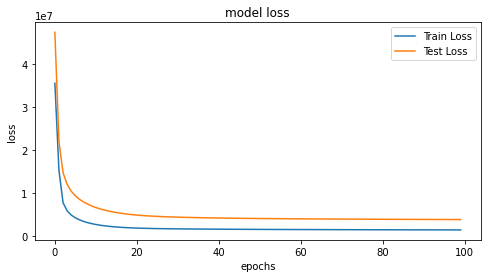

In [50]:
train_score = model.evaluate(trainX, trainY, verbose=0)
test_predict = model.predict(testX)

print('Train Root Mean Squared Error(RMSE): %.2f; Train Mean Absolute Error(MAE) : %.2f ' 
% (np.sqrt(train_score[1]), train_score[2]))
test_score = model.evaluate(testX, testY, verbose=0)
print('Test Root Mean Squared Error(RMSE): %.2f; Test Mean Absolute Error(MAE) : %.2f ' 
% (np.sqrt(test_score[1]), test_score[2]))
model_loss(history)

**Print out error metrics and generate model loss plot.**

### Step 5. Visualizing Prediction

In [51]:
def prediction_plot(testY, test_predict):
    len_prediction=[x for x in range(len(testY))]
    plt.figure(figsize=(8,4))
    plt.plot(len_prediction, testY[:], marker='.', label="actual")
    plt.plot(len_prediction, test_predict[:], 'r', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Sales', size=15)
    plt.xlabel('Dates', size=15)
    plt.legend(fontsize=15)
    plt.show();

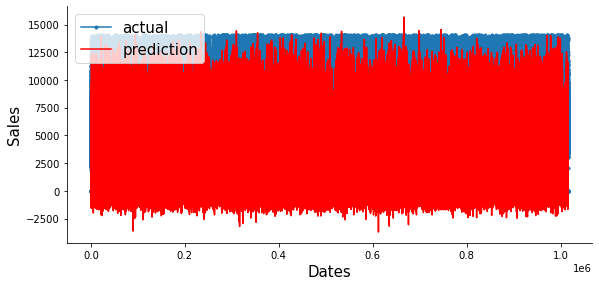

In [52]:
prediction_plot(testY, test_predict)

**From the plot, even though it misses some peaks and troughs, but it’s able to capture the overall trends and seasonality without any parameter tuning or normalization preprocessing.**

## Model 2: RNN
RNN(Recurrent Neural Network) handles sequences which is different from a fully connected DNN showed previously.

The key idea here: time-series datasets are sequences.

### Step 1: Data Preprocessing
- RNN input shape: (batch_size, window size, input_features)
- scalling 

In [53]:
sales_rnn = train_df[['Dates', 'Sales']].set_index('Dates')

In [58]:
sales_rnn.head(1)

,Sales
Dates,
2015-07-31,5263.0


In [60]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,])
        Y.append(data_arr[d,])
    return np.array(X), np.array(Y)

In [62]:
train_size = 40000
train,test = sales_rnn.values[0:train_size,:], sales_rnn.values[train_size:len(sales_rnn.values),:]
look_back = 30 #create window size as look_back=30
test = np.append(test,np.repeat(test[-1,], look_back))
train = np.append(train,np.repeat(train[-1,],look_back))
trainX,trainY =convert2matrix(train,look_back)
testX,testY =convert2matrix(test, look_back)
# reshape input to be [samples, window size, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

### Step 2: Define neural network shape and compile model

Built a RNN model with two hidden layers.

In [63]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.callbacks import EarlyStopping
def model_rnn(look_back):
    model=Sequential()
    model.add(SimpleRNN(units=32, input_shape=(1,look_back), activation="relu"))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
    return model

### Step 3: Fit Model

In [65]:
model=model_rnn(look_back)

history=model.fit(trainX,trainY, epochs=10, batch_size=30, verbose=1, validation_data=(testX,testY),
                  callbacks=[EarlyStopping(monitor='val_loss', patience=10)],shuffle=False)

2022/09/10 13:55:15 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5389def04ff94cd18da55aadd2a291af', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
   1/1334 [..............................] - ETA: 16:41 - loss: 5119458.0000 - mse: 5119458.0000 - mae: 1722.9589

1334/1334 [==============================] - 34s 25ms/step - loss: 3598496.2500 - mse: 3598496.2500 - mae: 1247.2543 - val_loss: 3332998.2500 - val_mse: 3332998.2500 - val_mae: 1150.1926
Epoch 2/10
1334/1334 [==============================] - 33s 25ms/step - loss: 3095491.7500 - mse: 3095491.7500 - mae: 1117.1426 - val_loss: 3183216.2500 - val_mse: 3183216.2500 - val_mae: 1111.2207
Epoch 3/10
1334/1334 [==============================] - 34s 25ms/step - loss: 2955568.0000 - mse: 2955568.0000 - mae: 1084.0511 - val_loss: 3071497.5000 - val_mse: 3071497.5000 - val_mae: 1084.2404
Epoch 4/10
1334/1334 [==============================] - 35s 26ms/step - loss: 2847247.2500 - mse: 2847247.5000 - mae: 1058.3606 - val_loss: 2971729.7500 - val_mse: 2971729.7500 - val_mae: 1060.8204
Epoch 5/10
1334/1334 [==============================] - 34s 25ms/step - loss: 2756613.0000 - mse: 2756613.0000 - mae: 1036.2258 - val_loss: 2895044.5000 - val_mse: 2895044.5000 - val_mae: 1041.7393
Epoch 6/10
1334/1334 

INFO:tensorflow:Assets written to: C:\Users\Ekubay\AppData\Local\Temp\tmpnglbu0nm\model\data\model\assets


In [66]:
# saving model
time = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
model.save(f'../models/sales_rnn-{time}.pkl')

INFO:tensorflow:Assets written to: ../models/sales_rnn-2022-09-10-11-04-34.pkl\assets


### Step 4: Model Evaluation
Print out error metrics and generate model loss plot.

30538/30538 [==============================] - 65s 2ms/step
Train Root Mean Squared Error(RMSE): 1542.37; train Mean Absolute Error(MAE) : 957.31 
Test Root Mean Squared Error(RMSE): 1614.09; test Mean Absolute Error(MAE) : 994.46 


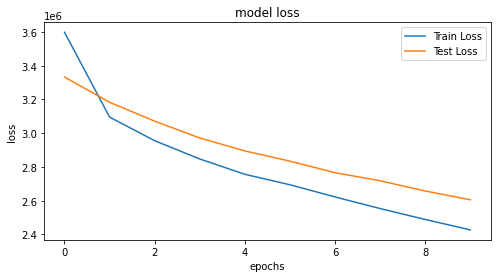

In [70]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
print('Train Root Mean Squared Error(RMSE): %.2f; train Mean Absolute Error(MAE) : %.2f '
      % (np.sqrt(mean_squared_error(trainY, train_predict[:,0])), mean_absolute_error(trainY, train_predict[:,0])))
print('Test Root Mean Squared Error(RMSE): %.2f; test Mean Absolute Error(MAE) : %.2f ' 
      % (np.sqrt(mean_squared_error(testY, test_predict[:,0])), mean_absolute_error(testY, test_predict[:,0])))
model_loss(history)

### Step 5. Visualizing Prediction

In [71]:
def prediction_plot(testY, test_predict, look_back):
    len_prediction=[x for x in range(len(testY))]
    plt.figure(figsize=(8,4))
    plt.plot(len_prediction, testY[:], marker='.', label="actual")
    plt.plot(len_prediction, test_predict[:], 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Sales', size=15)
    plt.xlabel('Dates', size=15)
    plt.legend(fontsize=15)
    plt.show();

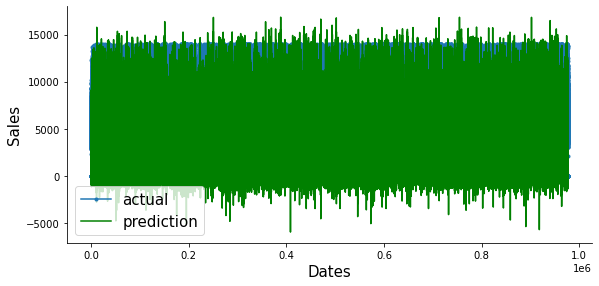

In [72]:
prediction_plot(testY, test_predict, look_back)

**In general, the prediction looks good with a smaller test errors. Even though it misses some peaks and troughs, but it’s able to capture the overall trends and seasonality.**

## Model 3: LSTM — one member of RNN families
LSTM(Long short-term memory), constructed by four main components: Input Gate, Output Gate, Memory Cell and Forget Gate

In [8]:
import numpy as np
import pandas as pd
import sys
import mlflow
import warnings
import pickle
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

## Step1: Data Preprocessing:
LSTMs are sensitive to the scale of the input data. During the Preprocessing step, I applied MinMaxScaler preprocessing class from the scikit-learn module to normalize/rescale dataset.

In [ ]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
    d=i+look_back  
    X.append(data_arr[i:d,])
    Y.append(data_arr[d,])
    return np.array(X), np.array(Y)

In [6]:
sales_lstm = df_train[["Dates", "Sales"]].set_index('Dates')

In [10]:
#sales.dtypes
scaler = MinMaxScaler()
scaler.fit(sales_lstm.Sales.values.reshape([-1, 1]))
SalesScaled = scaler.transform(sales_lstm.Sales.values.reshape(-1, 1))
sales_lstm['SalesScaled'] = SalesScaled
sales_lstm.head(5)

,Sales,SalesScaled
Dates,,
2015-07-31,5263.0,0.374617
2015-07-30,5020.0,0.357321
2015-07-29,4782.0,0.340380
2015-07-28,5011.0,0.356680
2015-07-27,6102.0,0.434337


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


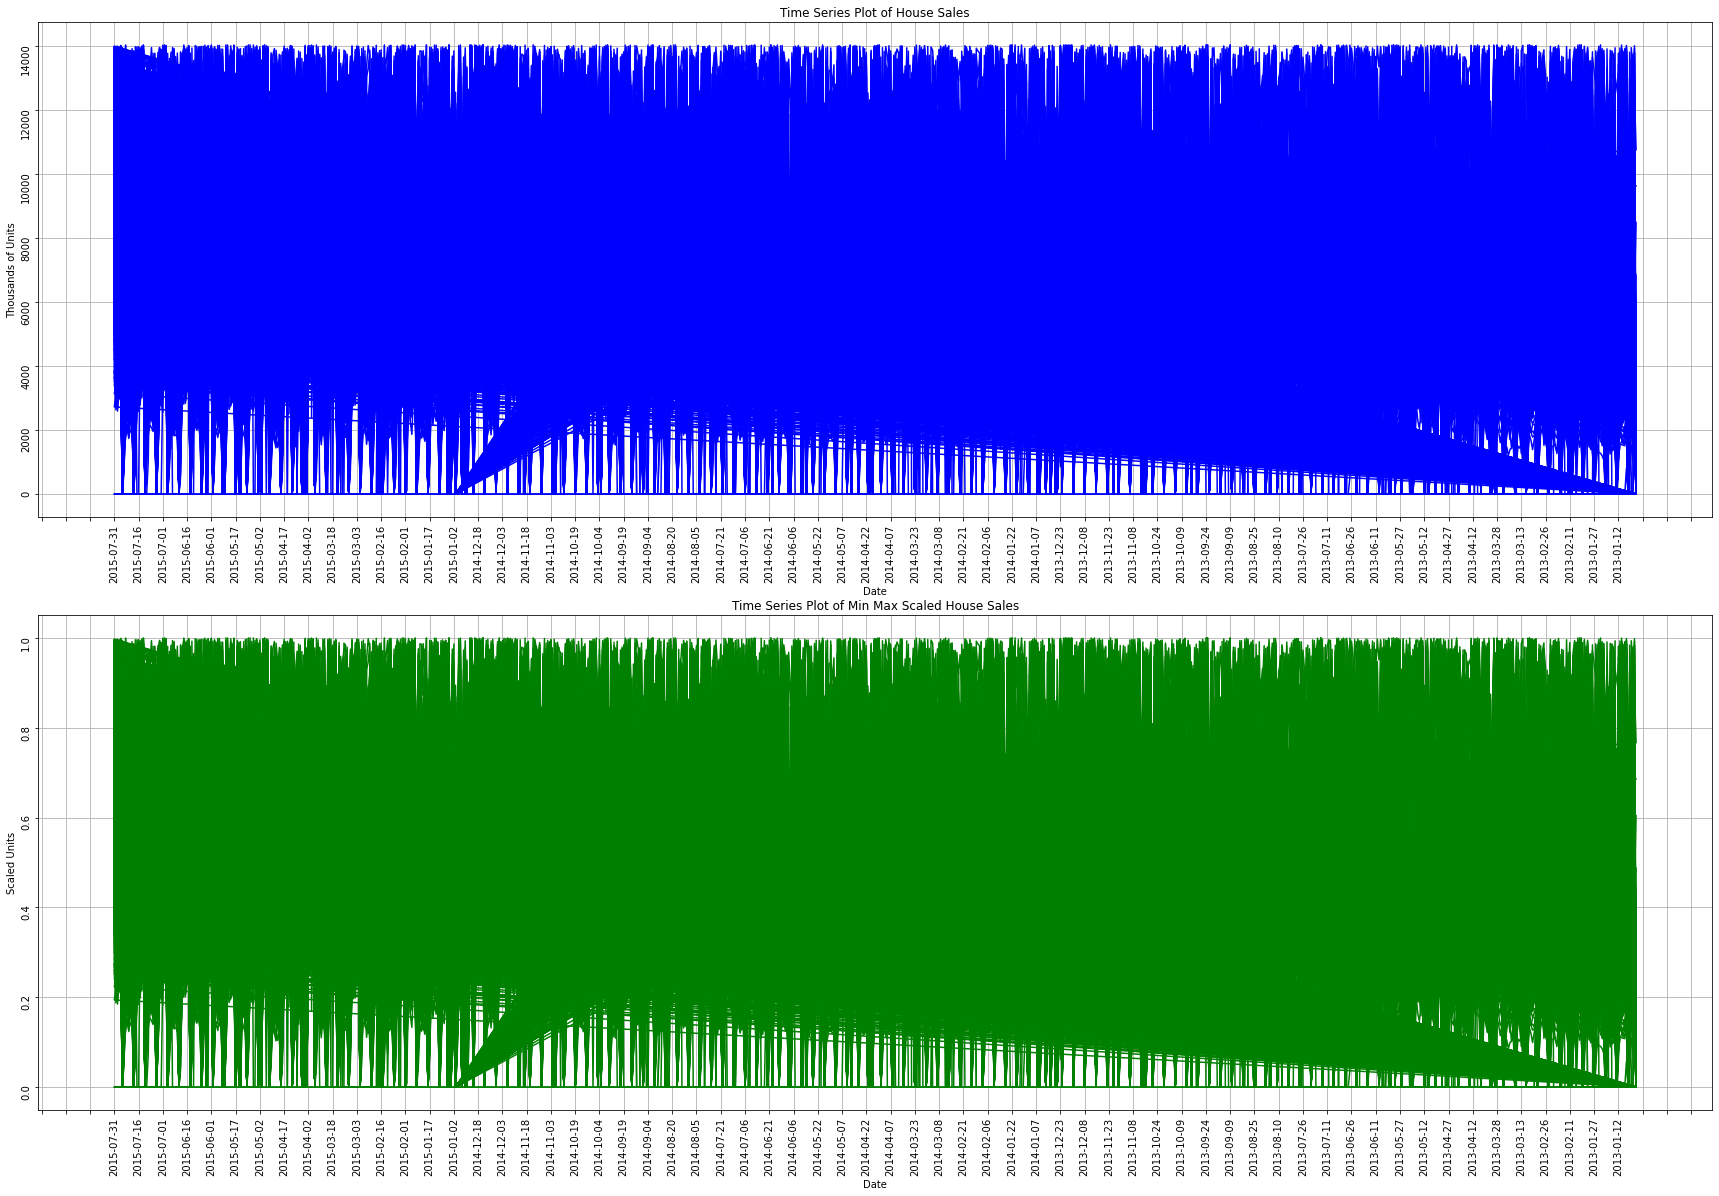

In [31]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 100
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(sales_lstm.index, sales_lstm.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands of Units')
ax1.title.set_text('Time Series Plot of Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.plot(sales_lstm.index, sales_lstm.SalesScaled, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text('Time Series Plot of Min Max Scaled Sales')
ax2.grid(True)
plt.show()

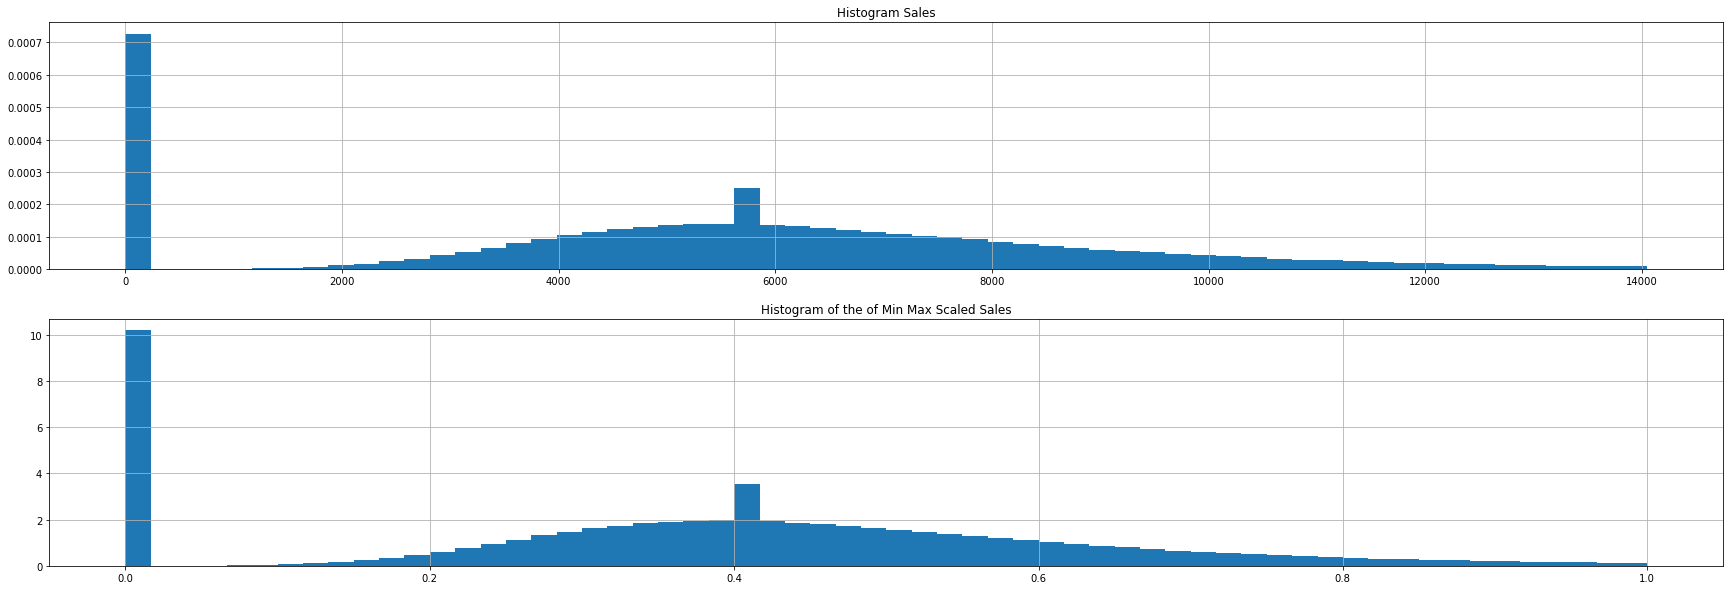

In [37]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0,0])
ax1.hist(sales_lstm.Sales, density=True, bins=60)
ax1.title.set_text('Histogram Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.hist(sales_lstm.SalesScaled, density=True, bins=60)
ax2.title.set_text('Histogram of the of Min Max Scaled Sales')
ax2.grid(True)
plt.show()

## Check whether the time Series Data is Stationary
Unit Root Tests helps us determine the stationarity of our data

In [11]:
from statsmodels.tsa.stattools import adfuller, acf, pacf

In [ ]:
# adfResult = adfuller(sales_lstm.Sales.values, autolag='AIC')
# print(f'ADF Statistic: {adfResult[0]}')
# print(f'p-value: {adfResult[1]}')

In [12]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

salesScaledDiff = difference(sales_lstm.SalesScaled.values)
salesScaledDiff

0         -0.017297
1         -0.016941
2          0.016300
3          0.077657
4         -0.434337
             ...   
1017203    0.339597
1017204   -0.016442
1017205   -0.017297
1017206   -0.042708
1017207   -0.263150
Length: 1017208, dtype: float64

Transform the time series data into supervised learning data by creating a new y(target) column. As illustrated here in the Sliding Window For Time Series Data section

In [13]:
acfSalesScaled = acf(sales_lstm.SalesScaled.values, fft=True, nlags=40)
acfSalesScaledNp = np.array(acfSalesScaled)

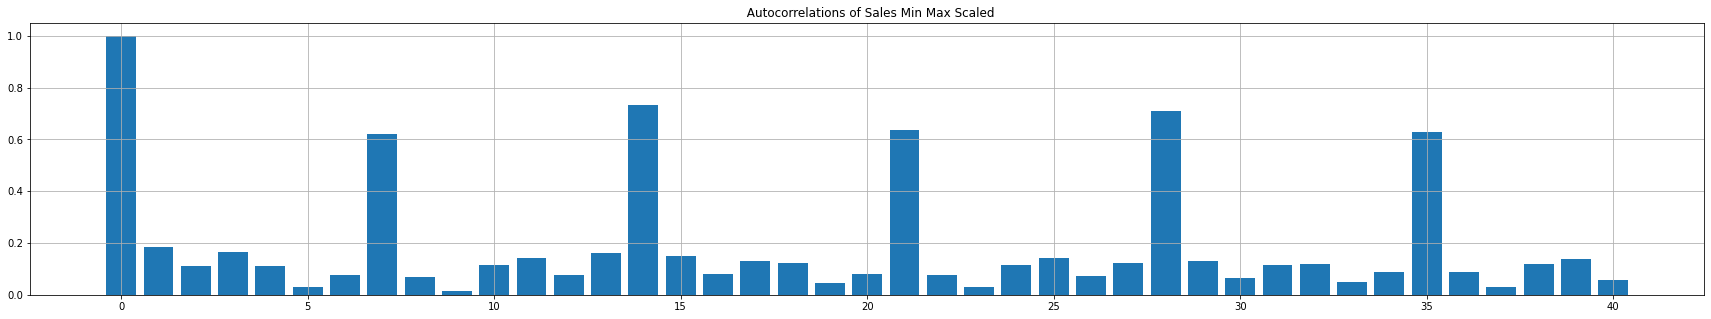

In [40]:
def corrPlots(array: np.array, prefix: str):
    plt.figure(figsize=(30, 5))
    plt.title(f"{prefix}  Autocorrelations of Sales Min Max Scaled")
    plt.bar(range(len(array)), array)
    plt.grid(True)
    plt.show()
corrPlots(acfSalesScaledNp, '')

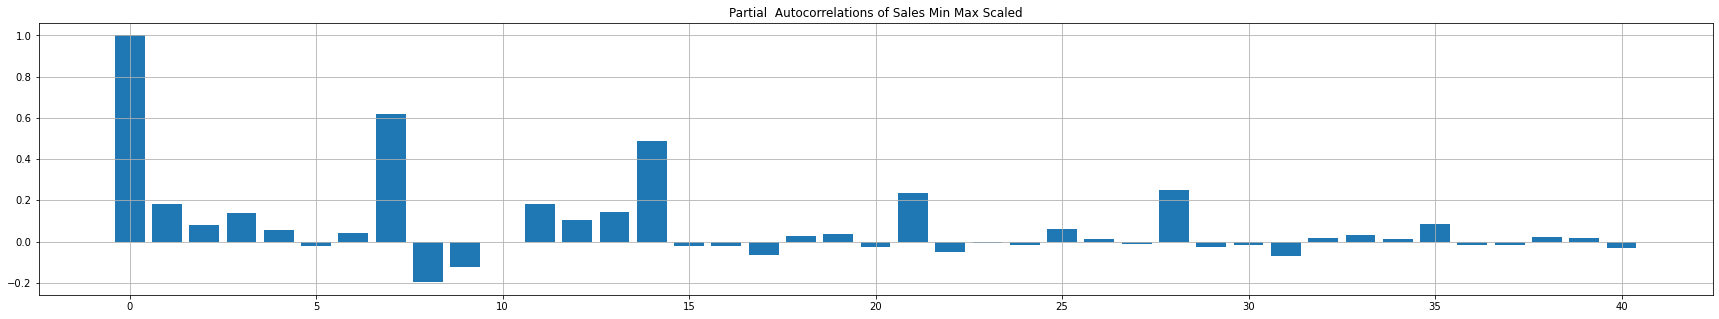

In [41]:
pacfSalesScaled = pacf(sales_lstm.SalesScaled.values, nlags=40)
pacfSalesScaledNp = np.array(pacfSalesScaled)
corrPlots(pacfSalesScaledNp, "Partial")

In [23]:
# setting window size
SIZE = len(sales_lstm.SalesScaled)
WINDOW_SIZE = 48
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 20

In [15]:
DateTrain = sales_lstm.index.values[0:BATCH_SIZE]
DateValid = sales_lstm.index.values[BATCH_SIZE:]
XTrain = sales_lstm.SalesScaled.values[0:BATCH_SIZE].astype('float32')
XValid = sales_lstm.SalesScaled.values[BATCH_SIZE:].astype('float32')

In [44]:
# shape
DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (1017113, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (1017113,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


In [16]:
tf.random.set_seed(1234)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([1017113, 1])

In [17]:
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float32, name=None)>

In [18]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True) 

In [19]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))

In [20]:
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [21]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE): 
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [22]:
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

In [24]:
# creating the model
model = Sequential()
model.add(LSTM(4, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="huber_loss", optimizer='adam')

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 8)           320       
                                                                 
 lstm_1 (LSTM)               (None, 4)                 208       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

Epoch 1/20


In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True) 
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(SIZE).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
Forecast = model_forecast(model, sales_df.SalesScaled.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1,1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1,1))

In [ ]:
plt.figure(figsize=(30, 8))
plt.title("LSTM Model Forecast Compared to Validation Data")
plt.plot(DateValid.astype('datetime64'), Results1, label='Forecast series')
plt.plot(DateValid.astype('datetime64'), np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
plt.xlabel('Date')
plt.ylabel('Thousands of Units')
plt.xticks(DateValid.astype('datetime64')[:,-1], rotation = 90) 
plt.legend(loc="upper right")

MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)

# place a text box in upper left in axes coords
plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
plt.grid(True)

plt.show()

In [ ]:
## below is using keras

In [257]:
#create numpy.ndarray
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray
df_arr= sales_df.values 
#sales_df.values = df_arr.astype('float32')
df_arr = np.reshape(df_arr, (-1, 1)) #LTSM requires more input features compared to RNN or DNN
scaler = MinMaxScaler(feature_range=(0, 1))#LTSM is senstive to the scale of features
df_arr = scaler.fit_transform(df_arr)

In [256]:
sales_df.dtypes

Sales    float64
dtype: object

In [227]:
print(len(df_arr))

942


# Using Keras 

## Step 1: Data Preprocessing

In [8]:
sales_lstm = df_train[["Dates", "Sales"]].set_index('Dates')

In [10]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,])
        Y.append(data_arr[d,])
    return np.array(X), np.array(Y)

In [12]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray
df_arr= sales_lstm.values 
#sales_lstm.values = df_arr.astype('float32')
df_arr = np.reshape(df_arr, (-1, 1)) #LTSM requires more input features compared to RNN or DNN
scaler = MinMaxScaler(feature_range=(0, 1))#LTSM is senstive to the scale of features
df_arr = scaler.fit_transform(df_arr)

**Split dataset into training and test dataset. Create input 3-D input shape for LSTM.**

In [14]:
train_size = 40000
test_size = len(df_arr) - train_size
train, test = df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
look_back = 30
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## Step 2: Define neural network shape and compile model
Here, a very simple two-layer LTSM without hidden layers

In [15]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
def model_lstm(look_back):
    model=Sequential()
    model.add(LSTM(100, input_shape=(1, look_back), activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
    return model

In [16]:
trainX.shape

(39970, 1, 30)

## Step 3: Fit model

In [18]:
model=model_lstm(look_back)

history = model.fit(trainX, trainY, epochs=10, batch_size=30, 
                    validation_data=(testX, testY), callbacks=[EarlyStopping(monitor='val_loss', 
                                                                             patience=10)], verbose=1, shuffle=False)

Epoch 1/10
1333/1333 [==============================] - 57s 42ms/step - loss: 0.0191 - mse: 0.0191 - mae: 0.0905 - val_loss: 0.0199 - val_mse: 0.0199 - val_mae: 0.0961
Epoch 2/10
1333/1333 [==============================] - 56s 42ms/step - loss: 0.0161 - mse: 0.0161 - mae: 0.0802 - val_loss: 0.0198 - val_mse: 0.0198 - val_mae: 0.0967
Epoch 3/10
1333/1333 [==============================] - 55s 41ms/step - loss: 0.0152 - mse: 0.0152 - mae: 0.0777 - val_loss: 0.0184 - val_mse: 0.0184 - val_mae: 0.0926
Epoch 4/10
1333/1333 [==============================] - 49s 37ms/step - loss: 0.0143 - mse: 0.0143 - mae: 0.0753 - val_loss: 0.0168 - val_mse: 0.0168 - val_mae: 0.0872
Epoch 5/10
1333/1333 [==============================] - 49s 37ms/step - loss: 0.0134 - mse: 0.0134 - mae: 0.0729 - val_loss: 0.0156 - val_mse: 0.0156 - val_mae: 0.0834
Epoch 6/10
1333/1333 [==============================] - 50s 38ms/step - loss: 0.0126 - mse: 0.0126 - mae: 0.0708 - val_loss: 0.0149 - val_mse: 0.0149 - val_mae:

## Step 4: Model Evaluation
- Print out error metrics and generate model loss plot.

In [21]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print('Train Root Mean Squared Error(RMSE): %.2f; Train Mean Absolute Error(MAE) : %.2f '% (np.sqrt(mean_squared_error(trainY[0], train_predict[:,0])),(mean_absolute_error(trainY[0], train_predict[:,0]))))
print('Test Root Mean Squared Error(RMSE): %.2f; Test Mean Absolute Error(MAE) : %.2f '% (np.sqrt(mean_squared_error(testY[0], test_predict[:,0])),(mean_absolute_error(testY[0], test_predict[:,0]))))
model_loss(history)

## 5. Visualization

In [28]:
def prediction_plots(testY, test_predict, look_back):
    len_prediction=[x for x in range(len(testY))]
    plt.figure(figsize=(8,4))
    plt.plot(len_prediction, testY[:], marker='.', label="actual")
    plt.plot(len_prediction, test_predict[:], 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Sales', size=15)
    plt.xlabel('Dates', size=15)
    plt.legend(fontsize=15)
    plt.show();

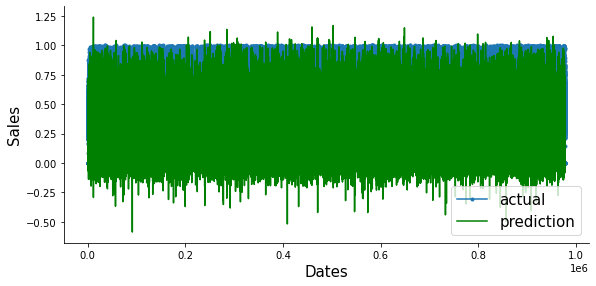

In [29]:
prediction_plots(testY, test_predict, 5)